## Enabling GPU on Colab

Need to enable GPU from Notebook settings

- Navigate to Edit-Notebook settings menu
- Select GPU from the Hardware Accelerator dropdown list


In [ ]:
import torch
import os

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
!ls

Mounted at /content/drive
/content
drive  sample_data


In [ ]:
!git clone https://github.com/sbalan7/XRayDenoising.git
!pwd

Cloning into 'XRayDenoising'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 52 (delta 8), reused 47 (delta 6), pack-reused 0
Unpacking objects: 100% (52/52), done.
/content


In [ ]:
%cd XRayDenoising
!ls

/content/XRayDenoising
 addnoise.py	   preprocess.py   README.md	      utility.py
 pca_analysis.py   __pycache__	  'Training Images'


## Synthetic images for demo training

In [ ]:
import torch
import torch.nn as nn
import torchvision.utils
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import addnoise
import cv2

# Generate some random images
no_of_images = 150
noise_type = np.random.randint(3, size=no_of_images)
image_sel = np.random.randint(26, size=no_of_images)
training_SNR = np.random.uniform(0, 10, size=(no_of_images, ))

In [ ]:
def add_noise(k, I, SNR):
    if k == 0:
        return addnoise.add_gaussian_noise(I, SNR)
    elif k == 1:
        return addnoise.add_poisson_noise(I, SNR)
    elif k == 2:
        return addnoise.add_salt_pepper_noise(I, SNR)
    return 'k somehow got an invalid value'

In [ ]:
processed_list = [_ for _ in os.listdir('Training Images/') if _.startswith('proc_')]

training_data_clean = np.array([cv2.imread('Training Images/'+filename, cv2.IMREAD_UNCHANGED) for filename in processed_list])
training_data_noisy = np.array([add_noise(noise_type[i], training_data_clean[image_sel[i]], np.power(10, training_SNR[i]/10)) for i in range(no_of_images)])

## Prepare Dataset and DataLoader

In [ ]:
class NoiseDataset(Dataset):
    def __init__(self, transform=None):
        self.input_images, self.output_images = training_data_noisy, training_data_clean[image_sel]
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        clean = self.output_images[idx]
        if self.transform:
            image = self.transform(image)
        return [image, clean]

train_set = NoiseDataset()
batch_size = 1
dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

## Check the outputs from DataLoader

torch.Size([1, 1000, 1000]) torch.Size([1, 1000, 1000])


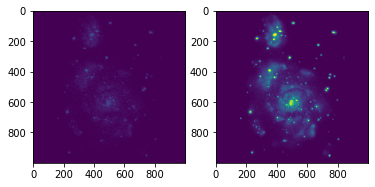

In [ ]:
# Get a batch of training data
inputs, clean = next(iter(dataloader))

print(inputs.shape, clean.shape)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(inputs[0])
axs[1].imshow(clean[0])

# Define the model

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class DenoisingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.downconv = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=19, stride=7),
            nn.ReLU(inplace=True),
            nn.Conv2d(5, 20, kernel_size=19, stride=9),
            nn.ReLU(inplace=True)
        )
        self.downlin = nn.Conv1d(1, 1, kernel_size=3521, stride=1)

        self.fcl = nn.Sequential(
            nn.Linear(400, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 400)
        )

        self.uplin = nn.ConvTranspose1d(1, 1, kernel_size=3521, stride=1)
        
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(20, 5, kernel_size=19, stride=7),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(5, 1, kernel_size=19, stride=9),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, input):
        x_down = self.downconv(input)
        x = self.downlin(x_down.view(1, -1))
        x = self.fcl(x)
        x = self.uplin(x)
        x_up = torch.reshape(x, (int(np.product(x.shape)/(20*14*14)), 20, 14, 14))
        output = self.upconv(x_up)
        return output

In [ ]:
model = DenoisingModel()
model = model.to(device)
model.apply(weights_init)

DenoisingModel(
  (downconv): Sequential(
    (0): Conv2d(1, 5, kernel_size=(19, 19), stride=(7, 7))
    (1): ReLU(inplace=True)
    (2): Conv2d(5, 20, kernel_size=(19, 19), stride=(9, 9))
    (3): ReLU(inplace=True)
  )
  (downlin): Conv1d(1, 1, kernel_size=(3521,), stride=(1,))
  (fcl): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=400, bias=True)
  )
  (uplin): ConvTranspose1d(1, 1, kernel_size=(3521,), stride=(1,))
  (upconv): Sequential(
    (0): ConvTranspose2d(20, 5, kernel_size=(19, 19), stride=(7, 7))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(5, 1, kernel_size=(19, 19), stride=(9, 9))
    (3): ReLU(inplace=True)
  )
)

In [ ]:
from torchsummary import summary
summary(model, input_size=(1, 1000, 1000))

RuntimeError: ignored

# Define the main training loop

In [ ]:
from collections import defaultdict
import torch.nn.functional as F

checkpoint_path = "checkpoint.pth"

def calc_loss(pred, target, metrics, bce_weight=0.75):
    bce = nn.MSELoss()
    loss = bce(pred[0], target) * bce_weight
    metrics['loss'] += loss.detach().cpu().numpy() * target.size(0)
    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    loss = calc_loss(outputs, labels.float(), metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
            
            if epoch % 50 == 0:
                print_metrics(metrics, epoch_samples, phase)

            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
              scheduler.step()
              if epoch % 50 == 0:
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss * 1.2 < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print(f'Epoch {epoch}/{num_epochs - 1} -- {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

## Training

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

model = DenoisingModel().to(device)

# freeze backbone layers
'''
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = False
'''

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.999)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=1500)

train: loss: 442.097999
LR 0.0001
val: loss: 367.777238
saving best model to checkpoint.pth
Epoch 0/1499 -- 0m 2s
Epoch 1/1499 -- 0m 1s
Epoch 2/1499 -- 0m 1s
Epoch 3/1499 -- 0m 1s
Epoch 4/1499 -- 0m 1s
Epoch 5/1499 -- 0m 1s
Epoch 6/1499 -- 0m 1s
Epoch 7/1499 -- 0m 1s
Epoch 8/1499 -- 0m 1s
Epoch 9/1499 -- 0m 1s
Epoch 10/1499 -- 0m 1s
Epoch 11/1499 -- 0m 1s
Epoch 12/1499 -- 0m 1s
Epoch 13/1499 -- 0m 1s
Epoch 14/1499 -- 0m 1s
Epoch 15/1499 -- 0m 1s
Epoch 16/1499 -- 0m 1s
Epoch 17/1499 -- 0m 1s
Epoch 18/1499 -- 0m 1s
Epoch 19/1499 -- 0m 1s
Epoch 20/1499 -- 0m 1s
Epoch 21/1499 -- 0m 1s
Epoch 22/1499 -- 0m 1s
Epoch 23/1499 -- 0m 1s
Epoch 24/1499 -- 0m 1s
Epoch 25/1499 -- 0m 1s
Epoch 26/1499 -- 0m 1s
Epoch 27/1499 -- 0m 1s
Epoch 28/1499 -- 0m 1s
Epoch 29/1499 -- 0m 1s
Epoch 30/1499 -- 0m 1s
Epoch 31/1499 -- 0m 1s
Epoch 32/1499 -- 0m 1s
Epoch 33/1499 -- 0m 1s
Epoch 34/1499 -- 0m 1s
Epoch 35/1499 -- 0m 1s
Epoch 36/1499 -- 0m 1s
Epoch 37/1499 -- 0m 1s
Epoch 38/1499 -- 0m 2s
Epoch 39/1499 -- 0m 1

In [ ]:
checkpoint_model = model

optimizer_super_train = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=7.5e-4)

exp_lr_super_train = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.999)

model = train_model(model, optimizer_super_train, exp_lr_super_train, num_epochs=3000)

train: loss: 336.850082
LR 0.00075


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


val: loss: 323.970791
saving best model to checkpoint.pth
Epoch 0/2999 -- 0m 2s
Epoch 1/2999 -- 0m 2s
Epoch 2/2999 -- 0m 1s
Epoch 3/2999 -- 0m 1s
Epoch 4/2999 -- 0m 1s
Epoch 5/2999 -- 0m 1s
Epoch 6/2999 -- 0m 1s
Epoch 7/2999 -- 0m 1s
Epoch 8/2999 -- 0m 1s
Epoch 9/2999 -- 0m 1s
Epoch 10/2999 -- 0m 1s
Epoch 11/2999 -- 0m 1s
Epoch 12/2999 -- 0m 1s
Epoch 13/2999 -- 0m 1s
Epoch 14/2999 -- 0m 1s
Epoch 15/2999 -- 0m 1s
Epoch 16/2999 -- 0m 1s
Epoch 17/2999 -- 0m 1s
Epoch 18/2999 -- 0m 1s
Epoch 19/2999 -- 0m 1s
Epoch 20/2999 -- 0m 1s
Epoch 21/2999 -- 0m 1s
Epoch 22/2999 -- 0m 1s
Epoch 23/2999 -- 0m 1s
Epoch 24/2999 -- 0m 1s
Epoch 25/2999 -- 0m 1s
Epoch 26/2999 -- 0m 1s
Epoch 27/2999 -- 0m 1s
Epoch 28/2999 -- 0m 2s
Epoch 29/2999 -- 0m 2s
Epoch 30/2999 -- 0m 1s
Epoch 31/2999 -- 0m 1s
Epoch 32/2999 -- 0m 1s
Epoch 33/2999 -- 0m 1s
Epoch 34/2999 -- 0m 1s
Epoch 35/2999 -- 0m 1s
Epoch 36/2999 -- 0m 1s
Epoch 37/2999 -- 0m 1s
Epoch 38/2999 -- 0m 1s
Epoch 39/2999 -- 0m 1s
Epoch 40/2999 -- 0m 1s
Epoch 41/

torch.Size([1, 1000, 1000])
torch.Size([1, 1000, 1000])
torch.Size([1, 1, 1000, 1000])


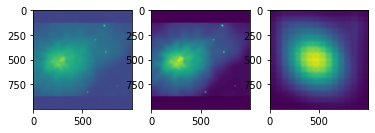

In [ ]:
batch_size = 1
test_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

t_inputs, t_clean = next(iter(test_dataloader))
print(t_inputs.shape)
print(t_clean.shape)

t_outputs = model(t_inputs.to(device).float())
print(t_outputs.shape)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(t_inputs[0])
axs[1].imshow(t_clean[0])
axs[2].imshow(t_outputs.detach().cpu()[0][0])